In [3]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
plt.style.use(style="ggplot")
import seaborn as sns

In [4]:
# read csv data

df_raw_raw=pd.read_csv("listings1.csv")
df_raw_raw = df_raw_raw.set_index('id')
df_ori=pd.read_csv("listings_original.csv")
df_ori = df_ori.set_index('id')

/Users/mac/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_raw=pd.concat([df_raw_raw,df_ori["extra_people"],df_ori["guests_included"]],axis=1)

In [6]:
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.drop(columns=['host_verifications'], inplace=True)

In [7]:
# data information

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 28078 entries, 6983.0 to 38969421.0
Data columns (total 41 columns):
host_since                          28052 non-null float64
host_response_rate                  13738 non-null float64
host_is_superhost                   28052 non-null float64
host_listings_count                 28052 non-null float64
host_has_profile_pic                28052 non-null float64
host_identity_verified              28052 non-null float64
zipcode                             27254 non-null float64
is_location_exact                   28076 non-null float64
property_type                       28076 non-null float64
room_type                           28076 non-null float64
accommodates                        28076 non-null float64
bathrooms                           28061 non-null float64
bedrooms                            28063 non-null float64
beds                                28055 non-null float64
bed_type                            28076 non-null fl

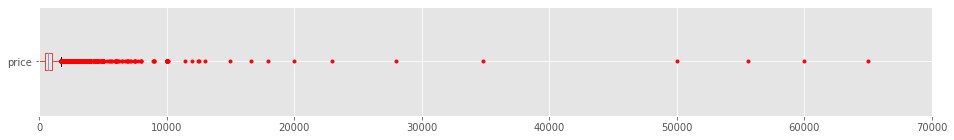

In [9]:
# plot price outliers

red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 70000), vert=False, flierprops=red_square, figsize=(16,2))

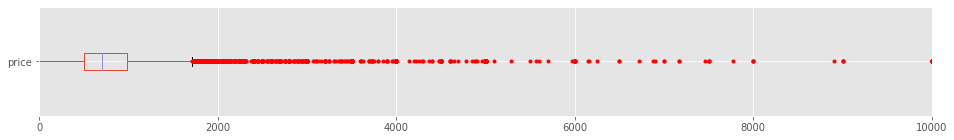

In [10]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 10000), vert=False, flierprops=red_square, figsize=(16,2))

In [11]:
# delete listings of price above 4000

df_raw.drop(df_raw[ (df_raw.price > 4000) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [12]:
# show price's mean, standard deviation, minimum, quartils, and maximum 
df_raw['price'].describe()

count    27944.000000
mean       797.042764
std        445.567157
min         68.000000
25%        499.000000
50%        703.000000
75%        976.000000
max       3999.000000
Name: price, dtype: float64

In [ ]:
# detect missing values

df_raw.isna().sum()

In [ ]:
# process missing values

df_raw.cleaning_fee.fillna(0, inplace=True)
df_raw.security_deposit.fillna(0, inplace=True)
df_raw.host_has_profile_pic.fillna(1,inplace=True)
df_raw.host_listings_count.fillna(0,inplace=True)
df_raw.host_identity_verified.fillna(0,inplace=True)

In [ ]:
df_raw.drop(columns=['square_feet', 'host_response_rate'], inplace=True)
df_raw.dropna(subset=["host_since",'bathrooms', "beds","review_scores_rating",
                      "review_scores_accuracy","review_scores_cleanliness",
                      'bedrooms', "review_scores_checkin","review_scores_communication",
                      "review_scores_location","review_scores_value","reviews_per_month","zipcode"], inplace=True)

In [ ]:
df_raw.info()

In [ ]:
# calculate distance to city center based on geographic information, latitude and longitude

from geopy.distance import great_circle
def distance_to_mid(lat, lon):
    Copenhagen_centre = (55.675929, 12.569074)
    accommodation = (lat, lon)
    return great_circle(Copenhagen_centre, accommodation).km
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [ ]:
# extract existing "size" from "description" feature

df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")
df_raw['size'] = df_raw['size'].astype(float)

print('NaNs in size_column absolute:     ', df_raw['size'].isna().sum())
print('NaNs in size_column in percentage:', round(df_raw['size'].isna().sum()/len(df_raw),3), '%')

In [ ]:
df_raw['size'].notna().sum()

In [ ]:
df_raw.drop(['description'], axis=1, inplace=True)

In [ ]:
# making dataframe for predicting size

sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

In [ ]:
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)
y_train = train_data['size']

In [ ]:
# using linear regression for predicting

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_test = linreg.predict(X_test)
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']

In [ ]:
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)

In [ ]:
new_test_data = pd.concat([X_test, y_test], axis=1)
sub_df_new = pd.concat([new_test_data, train_data], axis=0)
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

df = pd.concat([sub_df_new, df_raw], axis=1)

In [ ]:
# show size's mean, standard deviation, minimum, quartils, and maximum 

df['size'].describe()

In [ ]:
# plot size outliers

red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [ ]:
# delete size over 300 or equal to 0

df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)
print("The dataset has {} rows and {} columns - after being engineered.".format(*df.shape))

In [ ]:
# show features from "amendities"

from collections import Counter
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(40)

In [ ]:
# plot top 40 amendities

sub_df = pd.DataFrame(results.most_common(40), columns=['amenity', 'count'])
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

In [ ]:
'''
extract (TV,  Laptop_friendly_workspace, Family_kid_friendly, Host_greets_you, cooking_basics, 
Patio_or_balcony,garden_or_beckyard) as individual features
and delete "amendities" column
'''

df['TV'] = df['amenities'].str.contains('TV')
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['cooking_basics'] = df['amenities'].str.contains('Cooking basics')
df['Patio_or_balcony'] = df['amenities'].str.contains('Patio or balcony')
df['garden_or_beckyard'] = df['amenities'].str.contains('Garden or backyard')
df.drop(['amenities'], axis=1, inplace=True)

In [ ]:
# plot price vs lcoation

df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="hot_r", colorbar=True, sharex=False);

In [ ]:
# plot price vs price_per_bedroom

df_copy=df.copy()
df_copy["price_per_bedroom"]=df_copy["price"]/df_copy["bedrooms"]
df_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price_per_bedroom", cmap="hot_r", colorbar=True, sharex=False);

In [ ]:
# extract neighbourhood information 

neighbour=pd.read_csv("neighbourhood.csv", sep=';')   
nei={}
for i in neighbour.index:
    if neighbour.at[i,"area_code2"].astype(int)<=neighbour.at[i,"area_code1"].astype(int):
        celling=neighbour.at[i,"area_code1"].astype(int)+1
    else:
        celling=neighbour.at[i,"area_code2"].astype(int)+1
#         print(neighbour.at[i,"area_code1"].astype(int))
    nei[range(neighbour.at[i,"area_code1"].astype(int),celling)]=neighbour.at[i,"Neighbourhood"]

In [ ]:
def zip_to_dis(x):
    for i, j in enumerate(nei.keys()):
        if x in j:
            return nei[j]
df['neighbourhood'] = df.apply(lambda x: zip_to_dis(x.zipcode), axis=1)  
df['neighbourhood'].value_counts().sort_values()

In [ ]:
# delete listings in Herlev,Roedovre, Hvidovre, and Soeborg 

df_n=df.copy()
df_n=df_n.drop(df_n[df_n.neighbourhood=="Herlev"].index)
df_n=df_n.drop(df_n[df_n.neighbourhood=="Roedovre"].index)
df_n=df_n.drop(df_n[df_n.neighbourhood=="Hvidovre"].index)
df_n=df_n.drop(df_n[df_n.neighbourhood=="Soeborg"].index)

In [ ]:
# plot number of Accommodations per District

plt.figure(figsize=(8,8))
df_n['neighbourhood'].value_counts().sort_values().plot(kind='barh', color='IndianRed')
plt.title('Number of Accommodations per District');

In [ ]:
# plot Median Prices by Neighbourhood

df_grouped = pd.DataFrame(df_n.groupby(['neighbourhood'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood', y='price', 
                figsize=(10,6), legend=False, color='IndianRed')
plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

In [ ]:
# plot boxplot Prices by Neighbourhood

square = dict(markerfacecolor='IndianRed', markeredgecolor='IndianRed', marker='.')

df_n.boxplot(column='price', by='neighbourhood', 
           flierprops=square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')
plt.suptitle('');

In [ ]:
# heatmap for Median Prices by Neighbourhood and Number of Bedrooms

sns.set_style("dark")
plt.figure(figsize=(8,8))
sns.heatmap(df_n.groupby(['neighbourhood', 'bedrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

In [ ]:
# two plots showing relation between Distance and Median Price

df.plot.scatter(x="distance", y="price", figsize=(9,6), c='salmon')
plt.title('\nRelation between Distance and Median Price (1)\n', fontsize=14, fontweight='bold');

In [ ]:
sns.jointplot(x=df["distance"], y=df["price"], kind='hex')
plt.title('\nRelation between Distance and Median Price (2)\n',loc='center', fontsize=14, fontweight='bold');

In [ ]:
# dot plot showing relation between Size and Median Price

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size and Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [ ]:
# plot Median Prices by Cancellation Policy

df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');

In [ ]:
# split data 8:2 into train, test 
x = df.drop(["price","neighbourhood"],axis=1)
y=df["price"]
train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
# x_train

In [ ]:
'''
0-1 data normalization
MinMaxScaler subtracts the minimum value in the feature and then divides by the range. 
The range is the difference between the original maximum and original minimum

It preserves the shape of the original distribution 
without meaningfully change the information embedded in the original data.
'''

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [ ]:
# reduce data dimension using PCA

def pca(data):
    newData=data-np.mean(data,axis=0)
    covMat=np.cov(newData,rowvar=0)
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))
    idx = eigVals.argsort()[::-1]   
    eigVals = eigVals[idx]
    eigVects = eigVects[:,idx]
    return newData,eigVals,eigVects

normalized_x=np.vstack((train_X,test_X))
newData,eigVals,eigVects=pca(normalized_x)

In [ ]:
eigVects=np.array(eigVects)
x=range(1,len(eigVals)+1)
y=eigVals/eigVals[0]

plt.style.use(style="ggplot")
plt.title("Variance versus PC")
plt.plot(x,y,color="#800080",linewidth=2.0)
plt.show()

In [ ]:
cumulative=[]
k=0
for i in eigVals:
    k=k+i
    cumulative.append(k)
x=range(1,len(cumulative)+1)
y=cumulative/cumulative[-1]
y_p_90=0.95
y_p_95=0.98
plt.title("Cumulative variance versus PC")
plt.plot(x,y,color="#800080",linewidth=2.0)
# plt.scatter(x,y,color="#800080",marker = 'o')
plt.hlines(y_p_90, 1, 45, colors = "c", linestyles = "dashed",label='90% captured')
plt.hlines(y_p_95, 1, 45, colors = "black", linestyles = "dashed",label='95% captured')
plt.legend(loc='lower right')

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
pca_data=pca.fit_transform(normalized_x)

In [ ]:
# predict price using vanilla neural network 

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5, 2),random_state=1)
clf.fit(train_X, train_y)
pred_clf_y=clf.predict(test_X)

In [ ]:
# define estimator

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def estimator(pred_clf_y): 
    count=0
    for i,j in zip(list(pred_clf_y), test_y):
        if i>=j*0.7 and i<=j*1.3:
            count+=1

    RMSE = np.sqrt(mean_squared_error(test_y, pred_clf_y))
    r2 = r2_score(test_y, pred_clf_y)

    print("Confidence interval with a 30% margin of error: ", count/len(test_y))
    print("R2 score:", r2)
    print("Root Mean Square Error:", RMSE)
    print("Mean Absolute Error:",mean_absolute_error(test_y, pred_clf_y))

In [ ]:
'''
simple normalized data:
Confidence interval with a 30% margin of error:  0.6573007830492861
R2 score: 0.44310348809804456
Root Mean Square Error: 319.1596090627956
Mean Absolute Error: 204.1715799170889

after pca(25):
Confidence interval with a 30% margin of error:  0.6473975126669738
R2 score: 0.42803896338180203
Root Mean Square Error: 323.4475738450594
Mean Absolute Error: 207.6421004145555

'''


In [ ]:
# predcting using xgboost

import xgboost as xgb
booster = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=200, max_depth=7)

In [ ]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'learning_rate': [0.01, 0.05, 0.1], 
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(train_X, train_y)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

In [ ]:
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, 
                           max_depth=7, n_estimators=200, random_state=4, objective = 'reg:squarederror')

# train
booster.fit(train_X, train_y)

# predict
pred_train_y = booster.predict(train_X)
pred_test_y = booster.predict(test_X)

In [ ]:
estimator(pred_test_y)

In [ ]:
'''
Confidence interval with a 30% margin of error:  0.690234914785813
R2 score: 0.5821812990483937
Root Mean Square Error: 276.4487387027235
Mean Absolute Error: 186.20466291163166
'''

In [ ]:
feat_importances = pd.Series(booster.feature_importances_, index=x.columns)
feat_importances.nlargest(45).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,10))
plt.xlabel('Relative Feature Importance with XGBoost');

In [ ]:
np.sum((pd.Series(booster.feature_importances_, index=x.columns)["review_scores_rating"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_accuracy"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_cleanliness"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_checkin"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_communication"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_location"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_value"]))

In [ ]:
# predicting using lstm

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

In [ ]:
train_X.shape

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=400, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
'''
LSTM(50), epochs=200, batch_size=32: loss: 194.6626 - val_loss: 196.4582
LSTM(100), epochs=200, batch_size=32, loss: 188.9516 - val_loss: 194.9049
LSTM(100), epochs=200, batch_size=50, loss: 178.5542 - val_loss: 193.6281
LSTM(100), epochs=400, batch_size=16, loss: 170.2432 - val_loss: 193.5386

'''

In [ ]:
# make a prediction
pred_lstm_y = model.predict(test_X)

In [ ]:
# yhat[:100]

In [ ]:
count=0
for i,j in zip(list(pred_lstm_y), test_y):
    if i>=j*0.7 and i<=j*1.3:
        count+=1
        
RMSE = np.sqrt(mean_squared_error(test_y, pred_lstm_y))
r2 = r2_score(test_y, pred_lstm_y)

print("Confidence interval with a 30% margin of error: ", count/len(test_y))
print("R2 score:", r2)
print("Root Mean Square Error:", RMSE)
print("Mean Absolute Error:",mean_absolute_error(test_y, pred_lstm_y))

In [ ]:
'''
LSTM(100), epochs=400, batch_size=16:
Confidence interval with a 30% margin of error:  0.67918010133579
R2 score: 0.5350392398329429
Root Mean Square Error: 291.6277364088547
Mean Absolute Error: 193.53861458671636


'''